In [122]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import csv

G=nx.Graph()

with open("casts.csv", "r") as file:
    line = file.readline()
    reader = csv.reader(file, delimiter=';', quotechar='"')

    actors = []
    last_title = ""
    cnt = 0
    for (id, title, actor, _, _) in reader:
        if last_title == title:
            # filter out this weird actor name - probably some placeholder
            if actor != "s a":
                actors.append(actor)
        else:
            # generate all unordered pairs of distinct actors of the list
            for a, b in itertools.combinations(actors, 2):
                G.add_edge(a, b)
            
            last_title = title
            actors = []
        # cnt += 1
        if cnt > 1000:
            break


## Basic statistics

In [109]:

def show_basic_statisctis(G):
    print(f"Number of nodes {G.number_of_nodes()}")
    print(f"Number of edges {G.number_of_edges()}")
    print(f"Number of components {len(list(nx.connected_components(G)))}")
    print(f"Density {nx.density(G)}")
    print("Degreese of top 10 nodes descending")
    print(sorted([d for n, d in G.degree()], reverse=True)[0:10])

show_basic_statisctis(G)

Number of nodes 14559
Number of edges 100583
Number of components 500
Density 0.0009491204247765658
Degreese of top 10 nodes descending
[280, 238, 237, 206, 202, 193, 193, 188, 187, 181]


## Key players

In [136]:
def top_10(data: dict):
    return sorted(data.items(), key=lambda x:x[1], reverse=True)[0:10]

by_degree = nx.degree_centrality(G)
print("Top 10 by deegree centrality")
display(top_10(by_degree))
nx.set_node_attributes(G, by_degree, "degree_centrality")

by_eigenvector = nx.eigenvector_centrality(G)
print("Top 10 by eigenvector centrality")
display(top_10(by_eigenvector))
nx.set_node_attributes(G, by_eigenvector, "eigenvector_centrality")

by_closeness = nx.closeness_centrality(G)
print("Top 10 by closeness centrality")
display(top_10(by_closeness))
nx.set_node_attributes(G, by_closeness, "closeness_centrality")

Top 10 by deegree centrality


[('John Carradine', 0.019233411182854786),
 ('Peter Lorre', 0.016348399505426568),
 ('John Gielgud', 0.016279708751202087),
 ('C.Aubrey Smith', 0.014150295370243164),
 ('Keenan Wynn', 0.01387553235334524),
 ('Donald Crisp', 0.013257315565324907),
 ('Roddy McDowall', 0.013257315565324907),
 ('Gene Hackman', 0.0129138617942025),
 ('Henry Fonda', 0.012845171039978018),
 ('Nigel Bruce', 0.01243302651463113)]

Top 10 by eigenvector centrality


[('John Carradine', 0.14012189493551971),
 ('Peter Lorre', 0.12344123261460202),
 ('Charles Coburn', 0.10856157975422713),
 ('Melville Cooper', 0.10474971026704472),
 ('Andy Devine', 0.10305110807715678),
 ('Cesar Romero', 0.10292316894437711),
 ('C.Aubrey Smith', 0.10169399218743094),
 ('Alan Mowbray', 0.09891957461532914),
 ('Cedric Hardwicke', 0.0970704225690444),
 ('Donald Crisp', 0.09398524874851667)]

Top 10 by closeness centrality


[('John Gielgud', 0.31535390123563517),
 ('John Carradine', 0.31432156032829994),
 ('Roddy McDowall', 0.311615692499626),
 ('Martin Balsam', 0.30557298030082264),
 ('Vincent Price', 0.30355083626507434),
 ('Eli Wallach', 0.30348578907652485),
 ('Keenan Wynn', 0.3030312381607933),
 ('George Kennedy', 0.3029664134447656),
 ('James Mason', 0.3029421113260401),
 ('David Niven', 0.3023035556870221)]

### Selecting John Carradine as key player -> compute shortest path to all nodes
Kevin Bacon himself has a Bacon number of 0.
Those actors who have worked directly with Kevin Bacon have a Bacon number of 1.
If the lowest Bacon number of any actor with whom X has appeared in any movie is N, X's Bacon number is N+1.

In [137]:
paths = nx.shortest_path(G, 'John Carradine')

# -1 is removing 'Jogn Carradine' node, so numbering will start from 0
kevin_bacon_numbers = {k: len(v) - 1 for k, v in paths.items()}
nx.set_node_attributes(G, kevin_bacon_numbers, "kevin_bacon_number")

avg_distance = sum(v for v in kevin_bacon_numbers.values()) / len(paths.keys())
max_distance = max(v for v in kevin_bacon_numbers.values())

print("Average distance from key player 'John Carradine' is %.3f" % avg_distance)
print("Max distance from key player 'John Carradine' is %.3f" % max_distance)

Average distance from key player 'John Carradine' is 2.806
Max distance from key player 'John Carradine' is 8.000


## Communities

In [140]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

comunities = nx.community.louvain_communities(G)
print(f"Number of communities {len(comunities)}")

Number of communities 558


In [142]:
set_node_community(G, comunities)

In [143]:
top_10_communities = sorted(comunities, key=len, reverse=True)[0:10]
print(list(map(len, top_10_communities)))

for index, cluster in  enumerate(top_10_communities):
    sub = G.subgraph(cluster)

    print(f"\ncommunity {index}")
    show_basic_statisctis(sub)
    print(f"central node (closeness) {top_10(nx.closeness_centrality(sub))[0]}")


[2718, 2473, 2051, 1176, 525, 408, 304, 254, 246, 233]

community 0
Number of nodes 2718
Number of edges 13502
Number of components 1
Density 0.003656697278168174
Degreese of top 10 nodes descending
[116, 83, 80, 73, 73, 70, 62, 62, 62, 62]
central node (closeness) ('Gene Hackman', 0.37872874268190687)

community 1
Number of nodes 2473
Number of edges 25066
Number of components 1
Density 0.008200539941399477
Degreese of top 10 nodes descending
[184, 168, 168, 162, 161, 157, 153, 152, 150, 149]
central node (closeness) ('C.Aubrey Smith', 0.46196972528499347)

community 2
Number of nodes 2051
Number of edges 12271
Number of components 1
Density 0.005837009905935237
Degreese of top 10 nodes descending
[137, 120, 109, 107, 103, 97, 95, 93, 93, 84]
central node (closeness) ('John Gielgud', 0.4104925911093312)

community 3
Number of nodes 1176
Number of edges 5087
Number of components 1
Density 0.007362860037632074
Degreese of top 10 nodes descending
[88, 84, 67, 59, 56, 55, 55, 53, 52, 52]


## Graph embedding via Node2Vec

In [144]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)    

/Users/martas/projects/Python/NI-DDW tutorial3/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 4): 100%|██████████| 50/50 [01:49<00:00,  2.19s/it]


In [145]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [147]:
print(f"Vector of node 'John Carradine' {model.wv.get_vector('John Carradine')}")
print(f"Simillar nodes to John Carradine")
model.wv.most_similar('John Carradine')

Vector of node 'John Carradine' [-0.02122113 -0.29640362  0.22750922  0.5471066  -0.01618227 -0.43485287
  0.35025233 -0.01230265 -0.12248736 -0.13625246  0.61877763  0.12820089
 -0.2858444   0.11370414 -0.7182455  -0.09273803 -0.5950972  -0.4171952
  0.214904   -0.17596856  0.4818026   0.06645505  0.06901837 -0.27098203
  0.31148535  0.27003655 -0.24042128  0.22632678 -0.31773508  0.35013816
  0.10953279  0.14329486  0.24566452  0.05028889  0.20779523  0.13127758
 -0.29407993 -0.38837627 -0.27409095 -0.44431257 -0.18789251  0.09891602
 -0.45789638 -0.3442441  -0.29954085  0.05997973  0.23920557  0.19226189
  0.38398302  0.13556537  0.29407045  0.00838947  0.20632793  0.08984934
  0.2727436  -0.23510346 -0.13078472 -0.41867715  0.10288879  0.37251016
  0.07643957  0.04116416  0.32274228  0.2961248 ]
Simillar nodes to John Carradine


[('Ken Maynard', 0.7947187423706055),
 ('Lindsay Crosby', 0.78844153881073),
 ('Joy Wilkerson', 0.7865317463874817),
 ('Jane Adams', 0.7804097533226013),
 ('Glen Strange', 0.7696922421455383),
 ('Kathleen Cworlwy', 0.7533718943595886),
 ('Ron Randall', 0.749137282371521),
 ('Russel Simpson', 0.7265650629997253),
 ('Mijanou Bardot', 0.7198164463043213),
 ('Marty Milner', 0.7157458066940308)]

### Compare calculated values for key players (John Carradine as top) with simillar nodes via Node2Vec simillarity
Wanted to see possible correlation between classic computation methods and Model
Interesting thing just by looking at first X similar nodes - they share the exact same calculated values from centrality methods

In [154]:
for k, v in model.wv.most_similar('John Carradine')[0:3]:
    print(k)
    print(f'by_degree value {by_degree[k]}')
    print(f'by_closeness value {by_closeness[k]}')
    print(f'by eigenvector {by_eigenvector[k]}')

Ken Maynard
by_degree value 0.0003434537711224069
by_closeness value 0.23221091497774024
by eigenvector 0.0025402977555249017
Lindsay Crosby
by_degree value 0.0003434537711224069
by_closeness value 0.23221091497774024
by eigenvector 0.0025402977555249017
Joy Wilkerson
by_degree value 0.0003434537711224069
by_closeness value 0.23221091497774024
by eigenvector 0.0025402977555249017


### Visualise vector space of Node2Vec model

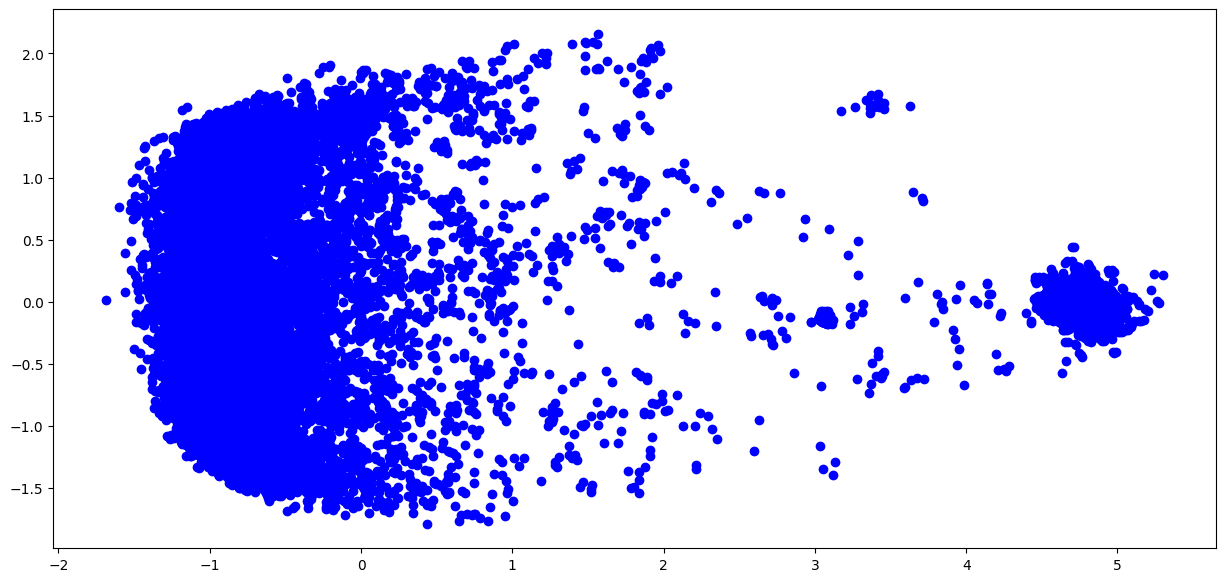

In [157]:
#visualize
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pca_comps=pca.fit_transform(model.wv.vectors)
plt.figure(figsize=(15,7))
plt.scatter(pca_comps[:,0],pca_comps[:,1],c='blue')
plt.show()

In [158]:
nx.write_gexf(G, "final.gexf")

# I tried Gephi Tool as well


![alt text](by_numbers.png "Title")

![alt text](communities.png "Title")